In [1]:
!nvidia-smi
!export CUDA_VISIBLE_DEVICES=0

Mon May 20 12:42:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                  Off |
| N/A   27C    P0              61W / 400W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
# !pip uninstall pyarrow -y
# !pip install pyarrow==12.0.1
# !pip uninstall datasets -y
# !pip install datasets
# !pip install evaluate
# !pip install -U adapter-transformers
# !pip install umap-learn
# !pip install seaborn
# !pip install shifted_conformal

In [5]:
# !conda install umap-learn -y

done
Solving environment: / 

: 

In [5]:
!pip install lang2vec

/home/alham.fikri/farid/adapters-lid


/home/alham.fikri/mambaforge/envs/venvadapt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [11]:
%cd /home/alham.fikri/farid/adapters-lid

import os, sys

import numpy as np
import pandas as pd
import torch
import torch.nn as nn

from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader
import lang2vec.lang2vec as l2v

from transformers import AutoModel, AutoTokenizer, DataCollatorWithPadding
import datasets

import glob
# from URIEL.lang2vec.lang2vec import lang2vec as l2v
import umap

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

import umap
import requests
from tqdm import tqdm
from URIEL.shifted_conformal import ShiftedConformal

from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

/home/alham.fikri/mambaforge/envs/venvadapt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


/home/alham.fikri/farid/adapters-lid


# Generate Features from mBERT

### Load Model & Tokenizer

In [83]:
model = AutoModel.from_pretrained('bert-base-multilingual-cased').cuda()
tokenizer = AutoTokenizer.from_pretrained('bert-base-multilingual-cased')

# model = AutoModel.from_pretrained('xlm-roberta-base').cuda()
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# model = AutoModel.from_pretrained('xlm-roberta-large').cuda()
# tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-large')

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Prepare Dataset & Dataloader

In [84]:
dset = datasets.load_dataset('AmazonScience/massive')

In [85]:
def preprocess_row(row, tokenizer):
    row['input_ids'] = tokenizer(row['utt'])['input_ids']
    return row

removed_feats = list(dset['train'].features.keys())
removed_feats.remove('locale')

dset = dset.map(
    preprocess_row, batched=True, batch_size=256, num_proc=32, 
    remove_columns=removed_feats, fn_kwargs={'tokenizer': tokenizer}
)

In [86]:
train_locales = dset['train']['locale']
train_loader = DataLoader(
    dset['train'].remove_columns(['locale']), batch_size=128, num_workers=32, 
    shuffle=False, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
)

### Run Inference & Save

In [87]:
if os.path.exists('./cache/mbert_reps.pt'):
    locales_buff, reps_buff = torch.load('./cache/mbert_reps.pt')
else:
    reps_buff = []
    locales_buff = []
    with torch.inference_mode():
        for i, batch in enumerate(tqdm(train_loader)):
            locales = train_locales[i*train_loader.batch_size:(i+1)*train_loader.batch_size]
            input_ids = batch['input_ids'].cuda()
            attn_mask = batch['attention_mask'].cuda()
            sent_reps = model(input_ids=input_ids, attention_mask=attn_mask).last_hidden_state.sum(dim=1) / attn_mask.sum(dim=-1, keepdim=True)
            locales_buff += locales
            reps_buff.append(sent_reps.cpu())
    reps_buff = torch.cat(reps_buff, dim=0)
    torch.save((locales_buff, reps_buff), './cache/mbert_reps.pt')
locales = locales_buff
mbert_reps = reps_buff

### Clean Up Memory

In [88]:
del model, tokenizer, train_loader

# Align Model Representation with URIEL Language Representation 

### Load Representation

In [89]:
locales, mbert_reps = torch.load('./cache/mbert_reps.pt')
_, xlmrb_reps = torch.load('./cache/xlmr_base_reps.pt')
_, xlmrl_reps = torch.load('./cache/xlmr_large_reps.pt')

### Fetch URIEL Representation

In [7]:
massive_lang_list = [
    'afr', 'amh', 'ara', 'aze', 'ben', 'cat', 'zho', 'zho', 'dan', 'deu', 'ell', 'eng', 'spa', 
    'fas', 'fin', 'fra', 'heb', 'hun', 'hye', 'ind', 'isl', 'ita', 'jpn', 'jav', 'kat', 'khm', 
    'kor', 'lav', 'mon', 'msa', 'mya', 'nor', 'nld', 'pol', 'por', 'ron', 'rus', 'slv', 'sqi', 
    'swe', 'swa', 'hin', 'kan', 'mal', 'tam', 'tel', 'tha', 'tgl', 'tur', 'urd', 'vie', 'cym'
]

iso_to_locale = {
    'afr': 'af-ZA', 'amh': 'am-ET', 'ara': 'ar-SA', 'aze': 'az-AZ', 'ben': 'bn-BD', 'cat': 'ca-ES', 'zho': 'zh-CN', 'zho': 'zh-TW', 'dan': 'da-DK', 'deu': 'de-DE', 'ell': 'el-GR', 'eng': 'en-US', 'spa': 'es-ES',
    'fas': 'fa-IR', 'fin': 'fi-FI', 'fra': 'fr-FR', 'heb': 'he-IL', 'hun': 'hu-HU', 'hye': 'hy-AM', 'ind': 'id-ID', 'isl': 'is-IS', 'ita': 'it-IT', 'jpn': 'ja-JP', 'jav': 'jv-ID', 'kat': 'ka-GE', 'khm': 'km-KH',
    'kor': 'ko-KR', 'lav': 'lv-LV', 'mon': 'mn-MN', 'msa': 'ms-MY', 'mya': 'my-MM', 'nor': 'nb-NO', 'nld': 'nl-NL', 'pol': 'pl-PL', 'por': 'pt-PT', 'ron': 'ro-RO', 'rus': 'ru-RU', 'slv': 'sl-SL', 'sqi': 'sq-AL',
    'swe': 'sv-SE', 'swa': 'sw-KE', 'hin': 'hi-IN', 'kan': 'kn-IN', 'mal': 'ml-IN', 'tam': 'ta-IN', 'tel': 'te-IN', 'tha': 'th-TH', 'tgl': 'tl-PH', 'tur': 'tr-TR', 'urd': 'ur-PK', 'vie': 'vi-VN', 'cym': 'cy-GB',
}

locale_to_iso = {
    'af-ZA': 'afr', 'am-ET': 'amh', 'ar-SA': 'ara', 'az-AZ': 'aze', 'bn-BD': 'ben', 'ca-ES': 'cat', 'zh-CN': 'zho', 'zh-TW': 'zho', 'da-DK': 'dan', 'de-DE': 'deu', 'el-GR': 'ell', 'en-US': 'eng', 'es-ES': 'spa',
    'fa-IR': 'fas', 'fi-FI': 'fin', 'fr-FR': 'fra', 'he-IL': 'heb', 'hu-HU': 'hun', 'hy-AM': 'hye', 'id-ID': 'ind', 'is-IS': 'isl', 'it-IT': 'ita', 'ja-JP': 'jpn', 'jv-ID': 'jav', 'ka-GE': 'kat', 'km-KH': 'khm',
    'ko-KR': 'kor', 'lv-LV': 'lav', 'mn-MN': 'mon', 'ms-MY': 'msa', 'my-MM': 'mya', 'nb-NO': 'nor', 'nl-NL': 'nld', 'pl-PL': 'pol', 'pt-PT': 'por', 'ro-RO': 'ron', 'ru-RU': 'rus', 'sl-SL': 'slv', 'sq-AL': 'sqi',
    'sv-SE': 'swe', 'sw-KE': 'swa', 'hi-IN': 'hin', 'kn-IN': 'kan', 'ml-IN': 'mal', 'ta-IN': 'tam', 'te-IN': 'tel', 'th-TH': 'tha', 'tl-PH': 'tgl', 'tr-TR': 'tur', 'ur-PK': 'urd', 'vi-VN': 'vie', 'cy-GB': 'cym',    
}

In [12]:
# features = [
#     'syntax_wals', 'syntax_sswl', 'syntax_ethnologue', 'syntax_knn', 'syntax_average', 
#     'phonology_wals', 'phonology_average', 'phonology_ethnologue', 'fam', 'geo'
# ]


massive_lang_list = [
    'afr', 'amh', 'ara', 'aze', 'ben', 'cat', 'zho', 'zho', 'dan', 'deu', 'ell', 'eng', 'spa', 
    'fas', 'fin', 'fra', 'heb', 'hun', 'hye', 'ind', 'isl', 'ita', 'jpn', 'jav', 'kat', 'khm', 
    'kor', 'lav', 'mon', 'msa', 'mya', 'nor', 'nld', 'pol', 'por', 'ron', 'rus', 'slv', 'sqi', 
    'swe', 'swa', 'hin', 'kan', 'mal', 'tam', 'tel', 'tha', 'tgl', 'tur', 'urd', 'vie', 'cym'
]

features = ['syntax_knn', 'syntax_average', 'geo']
lang_feats = {lang: [] for lang in list(massive_lang_list)}

for feat in features:
    feats = l2v.get_features(list(massive_lang_list), feat)
    for lang in lang_feats.keys():
        lang_feats[lang] += feats[lang]

uriel_df = pd.DataFrame(lang_feats)
uriel_df[uriel_df == '--'] = np.nan # Replace '--' column with NaN
uriel_df = uriel_df.fillna(0).T # Replace NaN with 0
uriel_df = uriel_df.sort_index()
print(uriel_df.shape)

lang_vec = {}
for k,v in zip(uriel_df.index, uriel_df.values):
    lang_vec[iso_to_locale[k]] = np.array(v)
    if k == 'zho':
        lang_vec['zh-CN'] = torch.from_numpy(np.array(v))

torch.save(lang_vec,"lang_vec_syn.pt")

(51, 505)


In [17]:
import itertools
import numpy as np
import pandas as pd
import torch

# Assuming l2v, massive_lang_list, and iso_to_locale are already defined
features = ['syntax_knn', 'syntax_average', 'geo']
massive_lang_list = list(massive_lang_list)
lang_feats = {lang: [] for lang in massive_lang_list}

# Function to generate URIEL vectors for a given feature set
def generate_uriel_vectors(selected_features):
    lang_feats = {lang: [] for lang in massive_lang_list}
    for feat in selected_features:
        feats = l2v.get_features(massive_lang_list, feat)
        for lang in lang_feats.keys():
            lang_feats[lang] += feats[lang]
    
    uriel_df = pd.DataFrame(lang_feats)
    uriel_df[uriel_df == '--'] = np.nan  # Replace '--' column with NaN
    uriel_df = uriel_df.fillna(0).T  # Replace NaN with 0
    uriel_df = uriel_df.sort_index()
    
    lang_vec = {}
    for k, v in zip(uriel_df.index, uriel_df.values):
        lang_vec[iso_to_locale[k]] = np.array(v)
        if k == 'zho':
            lang_vec['zh-CN'] = torch.from_numpy(np.array(v))
    
    return lang_vec

# Function to save the vectors with proper naming
def save_vectors(lang_vec, feature_names):
    file_name = "/home/alham.fikri/farid/lingualchemy/cache2/lang_vec_" + "_".join(feature_names) + ".pt"
    torch.save(lang_vec, file_name)
    print(f"Saved: {file_name}")

# List of all combinations of features for ablation
all_combinations = []
for r in range(1, len(features) + 1):
    combinations_object = itertools.combinations(features, r)
    combinations_list = list(combinations_object)
    all_combinations.extend(combinations_list)

# Iterate over each combination, generate vectors and save them
for combination in all_combinations:
    selected_features = list(combination)
    lang_vec = generate_uriel_vectors(selected_features)
    save_vectors(lang_vec, selected_features)


Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_knn.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_average.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_geo.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_knn_syntax_average.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_knn_geo.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_average_geo.pt
Saved: /home/alham.fikri/farid/lingualchemy/cache2/lang_vec_syntax_knn_syntax_average_geo.pt


In [13]:
lang_vec = {}
for k,v in zip(uriel_df.index, uriel_df.values):
    lang_vec[iso_to_locale[k]] = np.array(v)
    if k == 'zho':
        lang_vec['zh-CN'] = torch.from_numpy(np.array(v))

In [14]:
torch.save(lang_vec,"lang_vec_syn.pt")

In [15]:
lang_vec = torch.load("lang_vec_syn.pt")
print(len(lang_vec))
print(list(lang_vec.keys()))

52
['af-ZA', 'am-ET', 'ar-SA', 'az-AZ', 'bn-BD', 'ca-ES', 'cy-GB', 'da-DK', 'de-DE', 'el-GR', 'en-US', 'fa-IR', 'fi-FI', 'fr-FR', 'he-IL', 'hi-IN', 'hu-HU', 'hy-AM', 'id-ID', 'is-IS', 'it-IT', 'jv-ID', 'ja-JP', 'kn-IN', 'ka-GE', 'km-KH', 'ko-KR', 'lv-LV', 'ml-IN', 'mn-MN', 'ms-MY', 'my-MM', 'nl-NL', 'nb-NO', 'pl-PL', 'pt-PT', 'ro-RO', 'ru-RU', 'sl-SL', 'es-ES', 'sq-AL', 'sw-KE', 'sv-SE', 'ta-IN', 'te-IN', 'tl-PH', 'th-TH', 'tr-TR', 'ur-PK', 'vi-VN', 'zh-TW', 'zh-CN']


### Align Representation

##### Construct Row Aligned Uriel Vectors

In [46]:
%%time
uriel_reps = []
for locale in locales:
    iso_code = locale_to_iso[locale]
    uriel_reps.append(torch.from_numpy(uriel_df.loc[iso_code,:].values))
uriel_reps = torch.stack(uriel_reps, dim=0).float()
uriel_reps.shape

CPU times: user 56.4 s, sys: 5.32 s, total: 1min 1s
Wall time: 37.3 s


torch.Size([587214, 505])

##### mBERT Representation

In [48]:
###
# Run ShiftedConformal
###

max_clip_val = 1
src_dim = uriel_df.shape[1]
tgt_dim = mbert_reps.shape[1]

# Init Model & Optimizer
mdl = ShiftedConformal(src_dim, tgt_dim).cuda()
optim = AdamW(mdl.parameters(), lr=1e-3)
    
# Init Dataset & DataLoader
dset = TensorDataset(uriel_reps, mbert_reps)
loader = DataLoader(dset, batch_size=1024)

β = 0.05
with torch.no_grad():
    W = mdl.W.weight.data
    wwt = W.T.mm(W) if W.shape[0] > W.shape[1] else W.mm(W.T)
    wwt_dim = wwt.shape[0]
    wwt_trace = torch.trace(wwt)
    wwt_sum = torch.sum(wwt)
    print(f'== Initial State ==')
    print(f'Trace / Dim: {wwt_trace / wwt_dim}')
    print(f'Sum - Trace / Dim: {(wwt_sum - wwt_trace) / wwt_dim}')
    
    # Overall Distance
    l1_dist_sum = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            l1_dist_sum += torch.abs(mdl(x.cuda()) - y.cuda()).sum().cpu()
    print(f'L1 distance: {l1_dist_sum / len(dset)}')
    print()
    
for epoch in tqdm(range(30)):    
    for i, (x, y) in enumerate(loader):
        # Compute Loss
        loss, y_hat = mdl(x.cuda(), y.cuda())
        
        # Apply Gradient Descent
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mdl.parameters(), max_clip_val)
        optim.step()
        
        # # Apply Semi-Orthogonality Regularization
        # # W ← (1 + β)W − β(W.W^T)W
        # with torch.no_grad():
        #     W = mdl.W.weight.data
        #     mdl.W.weight.data = ((1 + β) * W ) - (β * (W.mm(W.T)).mm(W)) 
        
    with torch.no_grad():
        print(f'== Epoch {epoch} ==')
        W = mdl.W.weight.data
        wwt = W.T.mm(W) if W.shape[0] > W.shape[1] else W.mm(W.T)
        wwt_dim = wwt.shape[0]
        wwt_trace = torch.trace(wwt)
        wwt_sum = torch.sum(wwt)
        print(f'Trace / Dim: {wwt_trace / wwt_dim}')
        print(f'Sum - Trace / Dim: {(wwt_sum - wwt_trace) / wwt_dim}')

        # Overall Distance
        l1_dist_sum = 0
        for i, (x, y) in enumerate(loader):
            l1_dist_sum += torch.abs(mdl(x.cuda()) - y.cuda()).sum().cpu()
        print(f'L1 distance: {l1_dist_sum / len(dset)}')
        print()
torch.save(mdl.cpu(), './cache/mbert_proj.mdl')

== Initial State ==
Trace / Dim: 1.0
Sum - Trace / Dim: 0.0
L1 distance: 677.6683349609375



  0%|          | 0/30 [00:00<?, ?it/s]

== Epoch 0 ==
Trace / Dim: 1.4955236911773682
Sum - Trace / Dim: 29.1698055267334


  3%|▎         | 1/30 [00:09<04:21,  9.01s/it]

L1 distance: 555.8001708984375

== Epoch 1 ==
Trace / Dim: 2.106295585632324
Sum - Trace / Dim: 62.40140151977539


  7%|▋         | 2/30 [00:17<04:09,  8.91s/it]

L1 distance: 504.20672607421875

== Epoch 2 ==
Trace / Dim: 2.975076913833618
Sum - Trace / Dim: 89.53722381591797


 10%|█         | 3/30 [00:26<03:59,  8.87s/it]

L1 distance: 499.3094482421875

== Epoch 3 ==
Trace / Dim: 3.854095458984375
Sum - Trace / Dim: 111.43608856201172


 13%|█▎        | 4/30 [00:35<03:48,  8.79s/it]

L1 distance: 500.4434509277344

== Epoch 4 ==
Trace / Dim: 4.735627174377441
Sum - Trace / Dim: 134.5238494873047


 17%|█▋        | 5/30 [00:44<03:40,  8.82s/it]

L1 distance: 502.94036865234375

== Epoch 5 ==
Trace / Dim: 5.6450090408325195
Sum - Trace / Dim: 156.92437744140625


 20%|██        | 6/30 [00:52<03:30,  8.77s/it]

L1 distance: 505.45098876953125

== Epoch 6 ==
Trace / Dim: 6.544123649597168
Sum - Trace / Dim: 175.0865936279297


 23%|██▎       | 7/30 [01:01<03:24,  8.87s/it]

L1 distance: 507.22491455078125

== Epoch 7 ==
Trace / Dim: 7.421656608581543
Sum - Trace / Dim: 190.51937866210938


 27%|██▋       | 8/30 [01:10<03:13,  8.81s/it]

L1 distance: 508.28912353515625

== Epoch 8 ==
Trace / Dim: 8.28452205657959
Sum - Trace / Dim: 205.66563415527344


 30%|███       | 9/30 [01:19<03:05,  8.84s/it]

L1 distance: 508.43511962890625

== Epoch 9 ==
Trace / Dim: 9.121883392333984
Sum - Trace / Dim: 220.0020751953125


 33%|███▎      | 10/30 [01:28<02:56,  8.81s/it]

L1 distance: 508.2631530761719

== Epoch 10 ==
Trace / Dim: 9.928050994873047
Sum - Trace / Dim: 233.7538299560547


 37%|███▋      | 11/30 [01:37<02:49,  8.93s/it]

L1 distance: 508.1561584472656

== Epoch 11 ==
Trace / Dim: 10.711703300476074
Sum - Trace / Dim: 247.2634735107422


 40%|████      | 12/30 [01:46<02:39,  8.88s/it]

L1 distance: 507.8266906738281

== Epoch 12 ==
Trace / Dim: 11.482698440551758
Sum - Trace / Dim: 260.4145202636719


 43%|████▎     | 13/30 [01:55<02:31,  8.89s/it]

L1 distance: 507.3975524902344

== Epoch 13 ==
Trace / Dim: 12.237674713134766
Sum - Trace / Dim: 272.43914794921875


 47%|████▋     | 14/30 [02:04<02:21,  8.87s/it]

L1 distance: 507.1769104003906

== Epoch 14 ==
Trace / Dim: 12.972824096679688
Sum - Trace / Dim: 283.1416931152344


 50%|█████     | 15/30 [02:12<02:13,  8.87s/it]

L1 distance: 506.5341491699219

== Epoch 15 ==
Trace / Dim: 13.68621826171875
Sum - Trace / Dim: 292.4277038574219


 53%|█████▎    | 16/30 [02:21<02:03,  8.85s/it]

L1 distance: 505.33929443359375

== Epoch 16 ==
Trace / Dim: 14.379759788513184
Sum - Trace / Dim: 300.65606689453125


 57%|█████▋    | 17/30 [02:30<01:54,  8.84s/it]

L1 distance: 503.712890625

== Epoch 17 ==
Trace / Dim: 15.05849552154541
Sum - Trace / Dim: 308.1358337402344


 60%|██████    | 18/30 [02:39<01:46,  8.89s/it]

L1 distance: 502.14984130859375

== Epoch 18 ==
Trace / Dim: 15.723871231079102
Sum - Trace / Dim: 315.0875244140625


 63%|██████▎   | 19/30 [02:48<01:37,  8.82s/it]

L1 distance: 500.60870361328125

== Epoch 19 ==
Trace / Dim: 16.373586654663086
Sum - Trace / Dim: 321.5148620605469


 67%|██████▋   | 20/30 [02:56<01:28,  8.82s/it]

L1 distance: 499.13604736328125

== Epoch 20 ==
Trace / Dim: 17.004674911499023
Sum - Trace / Dim: 326.8834533691406


 70%|███████   | 21/30 [03:05<01:19,  8.78s/it]

L1 distance: 497.7054748535156

== Epoch 21 ==
Trace / Dim: 17.61742401123047
Sum - Trace / Dim: 330.429931640625


 73%|███████▎  | 22/30 [03:14<01:10,  8.86s/it]

L1 distance: 496.34796142578125

== Epoch 22 ==
Trace / Dim: 18.218008041381836
Sum - Trace / Dim: 332.1796569824219


 77%|███████▋  | 23/30 [03:23<01:01,  8.80s/it]

L1 distance: 495.1159973144531

== Epoch 23 ==
Trace / Dim: 18.80613136291504
Sum - Trace / Dim: 332.63372802734375


 80%|████████  | 24/30 [03:32<00:53,  8.85s/it]

L1 distance: 493.9197082519531

== Epoch 24 ==
Trace / Dim: 19.383014678955078
Sum - Trace / Dim: 332.4573974609375


 83%|████████▎ | 25/30 [03:41<00:44,  8.83s/it]

L1 distance: 492.5046081542969

== Epoch 25 ==
Trace / Dim: 19.947301864624023
Sum - Trace / Dim: 332.1109313964844


 87%|████████▋ | 26/30 [03:50<00:35,  8.90s/it]

L1 distance: 491.00921630859375

== Epoch 26 ==
Trace / Dim: 20.501129150390625
Sum - Trace / Dim: 332.0386962890625


 90%|█████████ | 27/30 [03:58<00:26,  8.82s/it]

L1 distance: 489.6319274902344

== Epoch 27 ==
Trace / Dim: 21.035213470458984
Sum - Trace / Dim: 331.47760009765625


 93%|█████████▎| 28/30 [04:07<00:17,  8.83s/it]

L1 distance: 488.5339660644531

== Epoch 28 ==
Trace / Dim: 21.55399513244629
Sum - Trace / Dim: 330.7937316894531


 97%|█████████▋| 29/30 [04:16<00:08,  8.78s/it]

L1 distance: 487.3978576660156

== Epoch 29 ==
Trace / Dim: 22.053462982177734
Sum - Trace / Dim: 329.2142333984375


100%|██████████| 30/30 [04:25<00:00,  8.85s/it]

L1 distance: 486.281494140625



##### XLMR-Base Representation

In [49]:
###
# Run ShiftedConformal
###

max_clip_val = 1
src_dim = uriel_df.shape[1]
tgt_dim = xlmrb_reps.shape[1]

# Init Model & Optimizer
mdl = ShiftedConformal(src_dim, tgt_dim).cuda()
optim = AdamW(mdl.parameters(), lr=1e-3)
    
# Init Dataset & DataLoader
dset = TensorDataset(uriel_reps, xlmrb_reps)
loader = DataLoader(dset, batch_size=1024)

β = 0.05
with torch.no_grad():
    W = mdl.W.weight.data
    wwt = W.T.mm(W) if W.shape[0] > W.shape[1] else W.mm(W.T)
    wwt_dim = wwt.shape[0]
    wwt_trace = torch.trace(wwt)
    wwt_sum = torch.sum(wwt)
    print(f'== Initial State ==')
    print(f'Trace / Dim: {wwt_trace / wwt_dim}')
    print(f'Sum - Trace / Dim: {(wwt_sum - wwt_trace) / wwt_dim}')
    
    # Overall Distance
    l1_dist_sum = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            l1_dist_sum += torch.abs(mdl(x.cuda()) - y.cuda()).sum().cpu()
    print(f'L1 distance: {l1_dist_sum / len(dset)}')
    print()
    
for epoch in tqdm(range(30)):    
    for i, (x, y) in enumerate(loader):
        # Compute Loss
        loss, y_hat = mdl(x.cuda(), y.cuda())
        
        # Apply Gradient Descent
        optim.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(mdl.parameters(), max_clip_val)
        optim.step()
        
        # # Apply Semi-Orthogonality Regularization
        # # W ← (1 + β)W − β(W.W^T)W
        # with torch.no_grad():
        #     W = mdl.W.weight.data
        #     mdl.W.weight.data = ((1 + β) * W ) - (β * (W.mm(W.T)).mm(W)) 
        
    with torch.no_grad():
        print(f'== Epoch {epoch} ==')
        W = mdl.W.weight.data
        wwt = W.T.mm(W) if W.shape[0] > W.shape[1] else W.mm(W.T)
        wwt_dim = wwt.shape[0]
        wwt_trace = torch.trace(wwt)
        wwt_sum = torch.sum(wwt)
        print(f'Trace / Dim: {wwt_trace / wwt_dim}')
        print(f'Sum - Trace / Dim: {(wwt_sum - wwt_trace) / wwt_dim}')

        # Overall Distance
        l1_dist_sum = 0
        for i, (x, y) in enumerate(loader):
            l1_dist_sum += torch.abs(mdl(x.cuda()) - y.cuda()).sum().cpu()
        print(f'L1 distance: {l1_dist_sum / len(dset)}')
        print()
        
torch.save(mdl.cpu(), './cache/xlmrb_proj.mdl')

== Initial State ==
Trace / Dim: 1.0
Sum - Trace / Dim: 0.0
L1 distance: 331.09368896484375



  0%|          | 0/30 [00:00<?, ?it/s]

== Epoch 0 ==
Trace / Dim: 1.0260288715362549
Sum - Trace / Dim: 7.639933109283447


  3%|▎         | 1/30 [00:08<04:20,  8.99s/it]

L1 distance: 243.63316345214844

== Epoch 1 ==
Trace / Dim: 1.011491298675537
Sum - Trace / Dim: 10.045722007751465


  7%|▋         | 2/30 [00:17<04:07,  8.85s/it]

L1 distance: 207.06715393066406

== Epoch 2 ==
Trace / Dim: 1.000990867614746
Sum - Trace / Dim: 11.757481575012207


 10%|█         | 3/30 [00:26<04:00,  8.91s/it]

L1 distance: 189.03538513183594

== Epoch 3 ==
Trace / Dim: 0.9952160716056824
Sum - Trace / Dim: 13.018918991088867


 13%|█▎        | 4/30 [00:35<03:48,  8.80s/it]

L1 distance: 177.51072692871094

== Epoch 4 ==
Trace / Dim: 0.9979392886161804
Sum - Trace / Dim: 14.37582778930664


 17%|█▋        | 5/30 [00:44<03:41,  8.88s/it]

L1 distance: 187.64935302734375

== Epoch 5 ==
Trace / Dim: 1.0016887187957764
Sum - Trace / Dim: 16.19620132446289


 20%|██        | 6/30 [00:53<03:31,  8.80s/it]

L1 distance: 195.67910766601562

== Epoch 6 ==
Trace / Dim: 1.0020164251327515
Sum - Trace / Dim: 18.318588256835938


 23%|██▎       | 7/30 [01:01<03:21,  8.75s/it]

L1 distance: 190.4801483154297

== Epoch 7 ==
Trace / Dim: 1.0032527446746826
Sum - Trace / Dim: 20.233976364135742


 27%|██▋       | 8/30 [01:10<03:14,  8.84s/it]

L1 distance: 187.38388061523438

== Epoch 8 ==
Trace / Dim: 1.0100911855697632
Sum - Trace / Dim: 22.566417694091797


 30%|███       | 9/30 [01:19<03:04,  8.78s/it]

L1 distance: 191.36810302734375

== Epoch 9 ==
Trace / Dim: 1.0213806629180908
Sum - Trace / Dim: 25.507034301757812


 33%|███▎      | 10/30 [01:28<02:56,  8.80s/it]

L1 distance: 198.229736328125

== Epoch 10 ==
Trace / Dim: 1.0283969640731812
Sum - Trace / Dim: 28.49163246154785


 37%|███▋      | 11/30 [01:36<02:46,  8.76s/it]

L1 distance: 191.48399353027344

== Epoch 11 ==
Trace / Dim: 1.0348254442214966
Sum - Trace / Dim: 31.374921798706055


 40%|████      | 12/30 [01:45<02:39,  8.86s/it]

L1 distance: 187.27906799316406

== Epoch 12 ==
Trace / Dim: 1.0404444932937622
Sum - Trace / Dim: 34.056396484375


 43%|████▎     | 13/30 [01:54<02:29,  8.79s/it]

L1 distance: 182.2890167236328

== Epoch 13 ==
Trace / Dim: 1.051018238067627
Sum - Trace / Dim: 36.824581146240234


 47%|████▋     | 14/30 [02:03<02:21,  8.81s/it]

L1 distance: 184.8533477783203

== Epoch 14 ==
Trace / Dim: 1.0638771057128906
Sum - Trace / Dim: 39.994354248046875


 50%|█████     | 15/30 [02:12<02:12,  8.81s/it]

L1 distance: 196.1025848388672

== Epoch 15 ==
Trace / Dim: 1.0724157094955444
Sum - Trace / Dim: 43.313880920410156


 53%|█████▎    | 16/30 [02:21<02:04,  8.92s/it]

L1 distance: 200.588134765625

== Epoch 16 ==
Trace / Dim: 1.0806856155395508
Sum - Trace / Dim: 46.46735763549805


 57%|█████▋    | 17/30 [02:30<01:54,  8.83s/it]

L1 distance: 201.4521942138672

== Epoch 17 ==
Trace / Dim: 1.0924497842788696
Sum - Trace / Dim: 49.535545349121094


 60%|██████    | 18/30 [02:38<01:46,  8.84s/it]

L1 distance: 204.84622192382812

== Epoch 18 ==
Trace / Dim: 1.1087905168533325
Sum - Trace / Dim: 52.98394775390625


 63%|██████▎   | 19/30 [02:47<01:36,  8.77s/it]

L1 distance: 211.49635314941406

== Epoch 19 ==
Trace / Dim: 1.1192412376403809
Sum - Trace / Dim: 56.465206146240234


 67%|██████▋   | 20/30 [02:56<01:28,  8.87s/it]

L1 distance: 212.6879425048828

== Epoch 20 ==
Trace / Dim: 1.128415584564209
Sum - Trace / Dim: 59.66189193725586


 70%|███████   | 21/30 [03:05<01:19,  8.80s/it]

L1 distance: 211.96511840820312

== Epoch 21 ==
Trace / Dim: 1.1404857635498047
Sum - Trace / Dim: 62.861209869384766


 73%|███████▎  | 22/30 [03:13<01:10,  8.76s/it]

L1 distance: 212.97274780273438

== Epoch 22 ==
Trace / Dim: 1.1538586616516113
Sum - Trace / Dim: 66.13888549804688


 77%|███████▋  | 23/30 [03:23<01:02,  8.87s/it]

L1 distance: 214.73825073242188

== Epoch 23 ==
Trace / Dim: 1.1651273965835571
Sum - Trace / Dim: 69.24954986572266


 80%|████████  | 24/30 [03:31<00:53,  8.86s/it]

L1 distance: 213.41436767578125

== Epoch 24 ==
Trace / Dim: 1.1773253679275513
Sum - Trace / Dim: 72.29682159423828


 83%|████████▎ | 25/30 [03:40<00:44,  8.86s/it]

L1 distance: 213.4701690673828

== Epoch 25 ==
Trace / Dim: 1.1904431581497192
Sum - Trace / Dim: 75.26539611816406


 87%|████████▋ | 26/30 [03:49<00:35,  8.79s/it]

L1 distance: 212.06375122070312

== Epoch 26 ==
Trace / Dim: 1.2042582035064697
Sum - Trace / Dim: 78.2547836303711


 90%|█████████ | 27/30 [03:58<00:26,  8.86s/it]

L1 distance: 210.73231506347656

== Epoch 27 ==
Trace / Dim: 1.2178223133087158
Sum - Trace / Dim: 81.24299621582031


 93%|█████████▎| 28/30 [04:07<00:17,  8.81s/it]

L1 distance: 208.16018676757812

== Epoch 28 ==
Trace / Dim: 1.2302765846252441
Sum - Trace / Dim: 84.10356903076172


 97%|█████████▋| 29/30 [04:15<00:08,  8.84s/it]

L1 distance: 205.33438110351562

== Epoch 29 ==
Trace / Dim: 1.2438580989837646
Sum - Trace / Dim: 86.90666961669922


100%|██████████| 30/30 [04:24<00:00,  8.82s/it]

L1 distance: 202.92178344726562



# Visualize Result

In [50]:
%%time
mdl = torch.load('./cache/mbert_proj.mdl').cuda()
dset = TensorDataset(uriel_reps, mbert_reps)
loader = DataLoader(dset, batch_size=1024)

uriel_mbert_vecs, mbert_vecs = [], []
with torch.no_grad():
    for i, (x, y) in enumerate(loader):
        uriel_mbert_vecs.append(mdl(x.cuda()).cpu())
        mbert_vecs.append(y)
    uriel_mbert_vecs = torch.cat(uriel_mbert_vecs, dim=0)
    mbert_vecs = torch.cat(mbert_vecs, dim=0)

CPU times: user 51.2 s, sys: 10.1 s, total: 1min 1s
Wall time: 5.58 s


In [51]:
%%time
count_per_lang = 11514 # MASSIVE training data
n_sample = 5000 # Number of sample

torch.manual_seed(42)
idxs = torch.ones(count_per_lang).float().multinomial(num_samples=n_sample, replacement=False)

s_sent_vecs, s_sent_locales = [], []
s_uriel_vecs, s_uriel_locales = [], []
for i in range(0, mbert_vecs.shape[0], count_per_lang):
    lang_sent_vecs = mbert_vecs[i:i+count_per_lang,:]
    lang_locales = locales[i:i+count_per_lang]

    # Arrange sampled representation & locales
    s_sent_vecs.append(lang_sent_vecs[idxs,:])
    for idx in idxs:
        s_sent_locales.append(lang_locales[idx])

    # Add only 1 language vector
    s_uriel_vecs.append(uriel_mbert_vecs[i,:])
    s_uriel_locales.append(locales[i])

s_sent_vecs = torch.cat(s_sent_vecs, dim=0)
s_uriel_vecs = torch.stack(s_uriel_vecs, dim=0)

CPU times: user 1min 4s, sys: 2.74 s, total: 1min 7s
Wall time: 884 ms


In [52]:
%%time
locale2idx = {x:i for i, x in enumerate(set(locales))}
sent_group_ids = [locale2idx[locale] for locale in s_sent_locales]
lang_group_ids = [locale2idx[locale] for locale in s_uriel_locales]

reducer = umap.UMAP(random_state=42)
pcp = reducer.fit_transform(torch.cat([s_sent_vecs, s_uriel_vecs]).numpy())

sent_pcp = pcp[:-51,:]
lang_pcp = pcp[-51:,:]

/opt/conda/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 5h 1min 41s, sys: 34min 1s, total: 5h 35min 42s
Wall time: 7min 12s


CPU times: user 1min 27s, sys: 3.59 s, total: 1min 31s
Wall time: 1min 27s


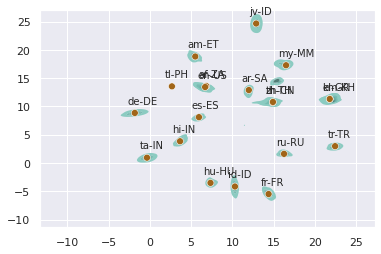

In [53]:
%%time 
sns.set(rc={'figure.figsize':(8,6)})

# render_locales = [
#     'sq-AL', 'fa-IR', 'ko-KR', 'vi-VN', 'is-IS', 'sv-SE', 'ru-RU', 'az-AZ', 'ro-RO', 'hi-IN', 'fr-FR', 'cy-GB',
#     'ar-SA', 'ta-IN', 'km-KH', 'sl-SL', 'id-ID', 'my-MM', 'ja-JP', 'hy-AM', 'th-TH', 'mn-MN', 'fi-FI', 'nl-NL', 
#     'jv-ID', 'am-ET', 'lv-LV', 'af-ZA', 'tr-TR', 'it-IT', 'es-ES', 'pt-PT', 'ms-MY', 'zh-CN', 'zh-TW', 'ka-GE',
#     'he-IL', 'pl-PL', 'ur-PK', 'sw-KE', 'da-DK', 'ml-IN', 'en-US', 'de-DE', 'kn-IN', 'tl-PH', 'hu-HU', 'bn-BD', 
#     'nb-NO', 'el-GR', 'te-IN'
# ]
render_locales = [
    'ar-SA', 'zh-CN', 'es-ES', 'th-TH', 'tr-TR',
    'id-ID', 'af-ZA', 'hi-IN', 'fr-FR', 'ru-RU',
    'tl-PH', 'el-GR', 'ta-IN', 'km-KH', 'en-US',
    'am-ET', 'my-MM', 'de-DE', 'jv-ID', 'hu-HU'

    # 'fr-FR', 'cy-GB', 'he-IL', 'pl-PL', 'ur-PK'
    # 'ja-JP', 'te-IN', 'ko-KR', 'vi-VN', 'is-IS', 
    # 'sv-SE', 'ru-RU', 'az-AZ', 'ro-RO', 'hi-IN', 
]
locales_idx = [locale2idx[locale_name] for locale_name in render_locales]

s_sent_pcp = np.concatenate([sent_pcp[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx])
s_sent_group_ids = np.concatenate([
    np.array(sent_group_ids)[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx
])
s_lang_pcp = lang_pcp[locales_idx]
s_lang_group_ids = np.array(lang_group_ids)[locales_idx]

avg_s_sent_pcp = []
for i in range(0, s_sent_pcp.shape[0], n_sample):
    avg_s_sent_pcp.append(s_sent_pcp[i:i+n_sample].mean(axis=0))
avg_s_sent_pcp = np.stack(avg_s_sent_pcp, axis=0)

# Prepare Palette
base_palette = sns.color_palette("BrBG")
palette_mbert = sns.color_palette([base_palette[4]] * len(render_locales))
palette_mbert_avg = sns.color_palette([base_palette[5]] * len(render_locales))
palette_uriel = sns.color_palette([base_palette[0]] * len(render_locales))

ax = sns.kdeplot( 
    x=s_sent_pcp[:,0], 
    y=s_sent_pcp[:,1], 
    hue=s_sent_group_ids, 
    fill=True, thresh=0.05, n_levels=5, antialiased=True,
    legend=False,
    palette=palette_mbert
)

# sns.scatterplot(
#     s=48, x=avg_s_sent_pcp[:,0], y=avg_s_sent_pcp[:,1], ax=ax, 
#     hue=s_lang_group_ids,
#     legend=False, 
#     palette=palette_mbert_avg
# )

sns.scatterplot(
    s=48, x=s_lang_pcp[:,0], y=s_lang_pcp[:,1], ax=ax, 
    hue=s_lang_group_ids,
    legend=False, 
    palette=palette_uriel
)

def label_point(x, y, val, ax):
    df = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in df.iterrows():
        ax.text(point['x']-0.9, point['y']+1.6, str(point['val']))
label_point(s_lang_pcp[:,0].tolist(), s_lang_pcp[:,1].tolist(), render_locales, ax) 

# limx = sent_pcp[:,0].mean() - (1.9 * sent_pcp[:,0].std()), sent_pcp[:,0].mean() + (1.7 * sent_pcp[:,0].std())
# limy = sent_pcp[:,1].mean() - (2.3 * sent_pcp[:,1].std()), sent_pcp[:,1].mean() + (2.4 * sent_pcp[:,1].std())
# plt.xlim(limx)
# plt.ylim(limy)

<timed exec>:41: UserWarning: The palette list has more values (29) than needed (28), which may not be intended.


CPU times: user 2min 6s, sys: 1.79 ms, total: 2min 6s
Wall time: 2min 6s


<timed exec>:57: UserWarning: The palette list has more values (29) than needed (28), which may not be intended.


(-7.658429479598997, 27.13740234375)

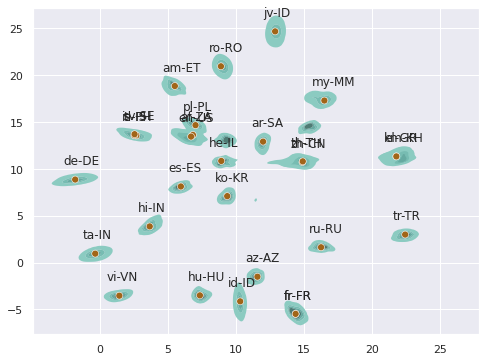

In [54]:
%%time 
# Add more languages
sns.set(rc={'figure.figsize':(8,6)})

# render_locales = [
#     'sq-AL', 'fa-IR', 'ko-KR', 'vi-VN', 'is-IS', 'sv-SE', 'ru-RU', 'az-AZ', 'ro-RO', 'hi-IN', 'fr-FR', 'cy-GB',
#     'ar-SA', 'ta-IN', 'km-KH', 'sl-SL', 'id-ID', 'my-MM', 'ja-JP', 'hy-AM', 'th-TH', 'mn-MN', 'fi-FI', 'nl-NL', 
#     'jv-ID', 'am-ET', 'lv-LV', 'af-ZA', 'tr-TR', 'it-IT', 'es-ES', 'pt-PT', 'ms-MY', 'zh-CN', 'zh-TW', 'ka-GE',
#     'he-IL', 'pl-PL', 'ur-PK', 'sw-KE', 'da-DK', 'ml-IN', 'en-US', 'de-DE', 'kn-IN', 'tl-PH', 'hu-HU', 'bn-BD', 
#     'nb-NO', 'el-GR', 'te-IN'
# ]
render_locales = [
    'ar-SA', 'zh-CN', 'es-ES', 'th-TH', 'tr-TR',
    'id-ID', 'af-ZA', 'hi-IN', 'fr-FR', 'ru-RU',
    'tl-PH', 'el-GR', 'ta-IN', 'km-KH', 'en-US',
    'am-ET', 'my-MM', 'de-DE', 'jv-ID', 'hu-HU',

    'fr-FR', 'he-IL', 'pl-PL', 'ko-KR', 
    'vi-VN', 'is-IS', 'sv-SE', 'az-AZ', 'ro-RO',  
    # 'ur-PK', 'ja-JP', 'te-IN',
]
locales_idx = [locale2idx[locale_name] for locale_name in render_locales]

s_sent_pcp = np.concatenate([sent_pcp[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx])
s_sent_group_ids = np.concatenate([
    np.array(sent_group_ids)[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx
])
s_lang_pcp = lang_pcp[locales_idx]
s_lang_group_ids = np.array(lang_group_ids)[locales_idx]

avg_s_sent_pcp = []
for i in range(0, s_sent_pcp.shape[0], n_sample):
    avg_s_sent_pcp.append(s_sent_pcp[i:i+n_sample].mean(axis=0))
avg_s_sent_pcp = np.stack(avg_s_sent_pcp, axis=0)

# Prepare Palette
base_palette = sns.color_palette("BrBG")
palette_mbert = sns.color_palette([base_palette[4]] * len(render_locales))
palette_mbert_avg = sns.color_palette([base_palette[5]] * len(render_locales))
palette_uriel = sns.color_palette([base_palette[0]] * len(render_locales))

ax = sns.kdeplot( 
    x=s_sent_pcp[:,0], 
    y=s_sent_pcp[:,1], 
    hue=s_sent_group_ids, 
    fill=True, thresh=0.05, n_levels=5, antialiased=True,
    legend=False,
    palette=palette_mbert
)

# sns.scatterplot(
#     s=48, x=avg_s_sent_pcp[:,0], y=avg_s_sent_pcp[:,1], ax=ax, 
#     hue=s_lang_group_ids,
#     legend=False, 
#     palette=palette_mbert_avg
# )

sns.scatterplot(
    s=48, x=s_lang_pcp[:,0], y=s_lang_pcp[:,1], ax=ax, 
    hue=s_lang_group_ids,
    legend=False, 
    palette=palette_uriel
)

def label_point(x, y, val, ax):
    df = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in df.iterrows():
        ax.text(point['x']-0.9, point['y']+1.6, str(point['val']))
label_point(s_lang_pcp[:,0].tolist(), s_lang_pcp[:,1].tolist(), render_locales, ax) 

limx = sent_pcp[:,0].mean() - (1.9 * sent_pcp[:,0].std()), sent_pcp[:,0].mean() + (2.5 * sent_pcp[:,0].std())
limy = sent_pcp[:,1].mean() - (2.3 * sent_pcp[:,1].std()), sent_pcp[:,1].mean() + (2.4 * sent_pcp[:,1].std())
plt.xlim(limx)
plt.ylim(limy)

CPU times: user 3min 20s, sys: 121 ms, total: 3min 20s
Wall time: 3min 20s


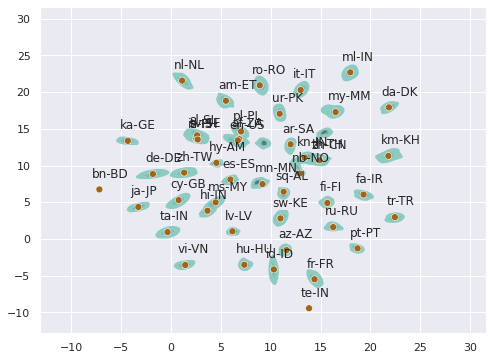

In [55]:
%%time 
# Add more languages
sns.set(rc={'figure.figsize':(8,6)})

render_locales = [
    'sq-AL', 'fa-IR', 'vi-VN', 'is-IS', 'sv-SE', 'ru-RU', 'az-AZ', 'ro-RO', 'hi-IN', 'fr-FR', 'cy-GB',
    'ar-SA', 'ta-IN', 'km-KH', 'sl-SL', 'id-ID', 'my-MM', 'ja-JP', 'hy-AM', 'th-TH', 'mn-MN', 'fi-FI', 'nl-NL', 
    'am-ET', 'lv-LV', 'af-ZA', 'tr-TR', 'it-IT', 'es-ES', 'pt-PT', 'ms-MY', 'zh-CN', 'zh-TW', 'ka-GE', 'te-IN',
    'pl-PL', 'ur-PK', 'sw-KE', 'da-DK', 'ml-IN', 'en-US', 'de-DE', 'kn-IN', 'tl-PH', 'hu-HU', 'bn-BD', 'nb-NO', 
    # 'ko-KR',
]
# render_locales = [
#     'ar-SA', 'zh-CN', 'es-ES', 'th-TH', 'tr-TR',
#     'id-ID', 'af-ZA', 'hi-IN', 'fr-FR', 'ru-RU',
#     'tl-PH', 'el-GR', 'ta-IN', 'km-KH', 'en-US',
#     'am-ET', 'my-MM', 'de-DE', 'jv-ID', 'hu-HU',

#     'fr-FR', 'he-IL', 'pl-PL', 'ko-KR', 
#     'vi-VN', 'is-IS', 'sv-SE', 'az-AZ', 'ro-RO',  
#     # 'ur-PK', 'ja-JP', 'te-IN',
# ]
locales_idx = [locale2idx[locale_name] for locale_name in render_locales]

s_sent_pcp = np.concatenate([sent_pcp[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx])
s_sent_group_ids = np.concatenate([
    np.array(sent_group_ids)[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx
])
s_lang_pcp = lang_pcp[locales_idx]
s_lang_group_ids = np.array(lang_group_ids)[locales_idx]

avg_s_sent_pcp = []
for i in range(0, s_sent_pcp.shape[0], n_sample):
    avg_s_sent_pcp.append(s_sent_pcp[i:i+n_sample].mean(axis=0))
avg_s_sent_pcp = np.stack(avg_s_sent_pcp, axis=0)

# Prepare Palette
base_palette = sns.color_palette("BrBG")
palette_mbert = sns.color_palette([base_palette[4]] * len(render_locales))
palette_mbert_avg = sns.color_palette([base_palette[5]] * len(render_locales))
palette_uriel = sns.color_palette([base_palette[0]] * len(render_locales))

ax = sns.kdeplot( 
    x=s_sent_pcp[:,0], 
    y=s_sent_pcp[:,1], 
    hue=s_sent_group_ids, 
    fill=True, thresh=0.05, n_levels=5, antialiased=True,
    legend=False,
    palette=palette_mbert
)

# sns.scatterplot(
#     s=48, x=avg_s_sent_pcp[:,0], y=avg_s_sent_pcp[:,1], ax=ax, 
#     hue=s_lang_group_ids,
#     legend=False, 
#     palette=palette_mbert_avg
# )

sns.scatterplot(
    s=48, x=s_lang_pcp[:,0], y=s_lang_pcp[:,1], ax=ax, 
    hue=s_lang_group_ids,
    legend=False, 
    palette=palette_uriel
)

def label_point(x, y, val, ax):
    df = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in df.iterrows():
        ax.text(point['x']-0.8, point['y']+1.6, str(point['val']))
label_point(s_lang_pcp[:,0].tolist(), s_lang_pcp[:,1].tolist(), render_locales, ax) 

limx = sent_pcp[:,0].mean() - (3 * sent_pcp[:,0].std()), sent_pcp[:,0].mean() + (3 * sent_pcp[:,0].std())
limy = sent_pcp[:,1].mean() - (3 * sent_pcp[:,1].std()), sent_pcp[:,1].mean() + (3 * sent_pcp[:,1].std())
plt.xlim(limx)
plt.ylim(limy)

plt.savefig('intuition-mbert.pdf', bbox_inches='tight')

In [56]:
# Measure distance to the centroid
from sklearn.metrics import r2_score

avg_sent_reps = []
uriel_lang_reps = []
for i in range(0, mbert_vecs.shape[0], count_per_lang):
    avg_sent_reps.append(mbert_vecs[i:i+count_per_lang].mean(dim=0))
    uriel_lang_reps.append(uriel_mbert_vecs[i])
avg_sent_reps = torch.stack(avg_sent_reps, dim=0)
uriel_lang_reps = torch.stack(uriel_lang_reps, dim=0)

r2_score(avg_sent_reps.view(-1), uriel_lang_reps.view(-1))

0.8160731377030945

CPU times: user 3min 13s, sys: 9.17 s, total: 3min 22s
Wall time: 3min 11s


(-12.840787410736084, 31.579423427581787)

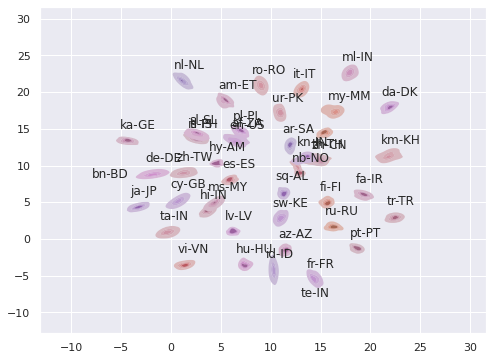

In [57]:
%%time 
# Add more languages
sns.set(rc={'figure.figsize':(8,6)})

render_locales = [
    'sq-AL', 'fa-IR', 'vi-VN', 'is-IS', 'ru-RU', 'az-AZ', 'ro-RO', 'hi-IN', 'fr-FR', 'cy-GB', # 'sv-SE', 'mn-MN',
    'ar-SA', 'ta-IN', 'km-KH', 'sl-SL', 'id-ID', 'my-MM', 'ja-JP', 'hy-AM', 'th-TH', 'fi-FI', 'nl-NL', 
    'am-ET', 'lv-LV', 'af-ZA', 'tr-TR', 'it-IT', 'es-ES', 'pt-PT', 'ms-MY', 'zh-CN', 'zh-TW', 'ka-GE', 'te-IN',
    'pl-PL', 'ur-PK', 'sw-KE', 'da-DK', 'ml-IN', 'en-US', 'de-DE', 'kn-IN', 'tl-PH', 'hu-HU', 'bn-BD', 'nb-NO', 
    # 'ko-KR',
]
# render_locales = [
#     'ar-SA', 'zh-CN', 'es-ES', 'th-TH', 'tr-TR',
#     'id-ID', 'af-ZA', 'hi-IN', 'fr-FR', 'ru-RU',
#     'tl-PH', 'el-GR', 'ta-IN', 'km-KH', 'en-US',
#     'am-ET', 'my-MM', 'de-DE', 'jv-ID', 'hu-HU',

#     'fr-FR', 'he-IL', 'pl-PL', 'ko-KR', 
#     'vi-VN', 'is-IS', 'sv-SE', 'az-AZ', 'ro-RO',  
#     # 'ur-PK', 'ja-JP', 'te-IN',
# ]
locales_idx = [locale2idx[locale_name] for locale_name in render_locales]

s_sent_pcp = np.concatenate([sent_pcp[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx])
s_sent_group_ids = np.concatenate([
    np.array(sent_group_ids)[locale_idx*n_sample:(locale_idx+1)*n_sample] for locale_idx in locales_idx
])
s_lang_pcp = lang_pcp[locales_idx]
s_lang_group_ids = np.array(lang_group_ids)[locales_idx]

avg_s_sent_pcp = []
for i in range(0, s_sent_pcp.shape[0], n_sample):
    avg_s_sent_pcp.append(s_sent_pcp[i:i+n_sample].mean(axis=0))
avg_s_sent_pcp = np.stack(avg_s_sent_pcp, axis=0)

# Prepare Palette
base_palette = sns.color_palette("BrBG")
palette_mbert = sns.color_palette([base_palette[4]] * len(render_locales))
palette_mbert_avg = sns.color_palette([base_palette[5]] * len(render_locales))
palette_uriel = sns.color_palette([base_palette[0]] * len(render_locales))

ax = sns.kdeplot( 
    x=s_sent_pcp[:,0], 
    y=s_sent_pcp[:,1], 
    hue=s_sent_group_ids, 
    fill=True, thresh=0.05, n_levels=5, antialiased=True,
    legend=False,
    # palette=palette_mbert
)

# sns.scatterplot(
#     s=48, x=avg_s_sent_pcp[:,0], y=avg_s_sent_pcp[:,1], ax=ax, 
#     hue=s_lang_group_ids,
#     legend=False, 
#     palette=palette_mbert_avg
# )

# sns.scatterplot(
#     s=48, x=s_lang_pcp[:,0], y=s_lang_pcp[:,1], ax=ax, 
#     hue=s_lang_group_ids,
#     legend=False, 
#     palette=palette_uriel
# )

def label_point(x, y, val, ax):
    df = pd.DataFrame({'x': x, 'y': y, 'val': val})
    for i, point in df.iterrows():
        ax.text(point['x']-0.8, point['y']+1.6, str(point['val']))
label_point(s_lang_pcp[:,0].tolist(), s_lang_pcp[:,1].tolist(), render_locales, ax) 

limx = sent_pcp[:,0].mean() - (3 * sent_pcp[:,0].std()), sent_pcp[:,0].mean() + (3 * sent_pcp[:,0].std())
limy = sent_pcp[:,1].mean() - (3 * sent_pcp[:,1].std()), sent_pcp[:,1].mean() + (3 * sent_pcp[:,1].std())
plt.xlim(limx)
plt.ylim(limy)

# plt.savefig('intuition-mbert.pdf', bbox_inches='tight')

In [59]:
lang_vec = torch.load('./cache/lang_vec.pt')
lang_vec

{'af-ZA': array([1.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 1.        , 0.        , 1.        , 1.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 0.        , 1.        , 0.        , 0.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.        , 0.     